In [1]:
"""
base solver for transfer ode (first order methods)
"""
import torch
import torch.nn as nn
import argparse
import torch.optim as optim
import numpy as np
import time
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from torchdiffeq import odeint_adjoint as odeint
from mpl_toolkits.mplot3d import Axes3D
import random
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter

%matplotlib inline


parser = argparse.ArgumentParser('transfer demo')

parser.add_argument('--tmax', type=float, default=3.)
parser.add_argument('--dt', type=int, default=0.1)
parser.add_argument('--niters', type=int, default=5000)
parser.add_argument('--niters_test', type=int, default=5000)
parser.add_argument('--hidden_size', type=int, default=200)
parser.add_argument('--num_bundles', type=int, default=100)
parser.add_argument('--num_bundles_test', type=int, default=1000)
parser.add_argument('--test_freq', type=int, default=10)
parser.add_argument('--viz', action='store_false')
parser.add_argument('--gpu', type=int, default=0)
parser.add_argument('--evaluate_only', action='store_true')
args = parser.parse_args([])



/Users/shaan/anaconda3/envs/main/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
args.niters_test

5000

In [3]:
# print(args.evaluate_only==False)

class diffeq(nn.Module):
    """
    defines the diffeq of interest
    """

    def __init__(self, a0, f):
        super().__init__()
        # self.a1 = a1
        self.a0 = a0
        self.f = f

    # return ydot
    def forward(self, t, y):
        # y = y[:, 0]
        yd = get_udot(t,y,self.a0,self.f)#(-self.a0(t) * y + self.f(t)) / self.a1(t)
        return yd


def get_udot(t,y,a,f):

    #a1 is 1
    # print(t.dim())
    if y.shape[0] <=1:
        a0 = torch.tensor([a_(t) for a_ in a]).reshape(1,-1)
        f0 = torch.tensor([f_(t) for f_ in f]).reshape(1,-1)
    else:
        a0 = torch.cat([a_(t) for a_ in a],1)
        f0 = torch.cat([f_(t) for f_ in f],1)

    yd = (-a0 * y + f0)
    return yd


class base_diffeq:
    """
    integrates base_solver given y0 and time
    """

    def __init__(self, base_solver):
        self.base = base_solver

    def get_solution(self, true_y0, t):
        with torch.no_grad():
            true_y = odeint(self.base, true_y0, t, method='dopri5')
        return true_y

    def get_deriv(self, true_y0, t):
        with torch.no_grad():
            true_ydot = self.base(t, true_y0)
        return true_ydot


class estim_diffeq:
    """
    integrates base_solver given y0 and time
    """

    def __init__(self, base_solver):
        self.base = base_solver

    def get_solution(self, true_y0, t):
        with torch.no_grad():
            true_y = odeint(self.base, true_y0, t, method='midpoint')
        return true_y

    def get_deriv(self, true_y0, t):
        with torch.no_grad():
            true_ydot = self.base(t, true_y0)
        return true_ydot


class ODEFunc(nn.Module):
    """
    function to learn the outputs u(t) and hidden states h(t) s.t. u(t) = h(t)W_out
    """

    def __init__(self, hidden_dim, output_dim):
        super(ODEFunc, self).__init__()
        self.hdim = hidden_dim
        self.nl = nn.Tanh()
        self.lin1 = nn.Linear(1, self.hdim)
        self.lin2 = nn.Linear(self.hdim, self.hdim)
        self.lout = nn.Linear(self.hdim, output_dim, bias=True)

    def forward(self, t):
        x = self.h(t)
        x = self.lout(x)
        return x

    def wouts(self, x):
        return self.lout(x)

    def h(self, t):
        x = self.lin1(t)
        x = self.nl(x)
        x = self.lin2(x)
        x = self.nl(x)
        return x


def diff(u, t, order=1):
    # code adapted from neurodiffeq library
    # https://github.com/NeuroDiffGym/neurodiffeq/blob/master/neurodiffeq/neurodiffeq.py
    r"""The derivative of a variable with respect to another.
    """
    # ones = torch.ones_like(u)

    der = torch.cat([torch.autograd.grad(u[:, i].sum(), t, create_graph=True,allow_unused=True)[0] for i in range(u.shape[1])], 1)
    if der is None:
        print('derivative is None')
        return torch.zeros_like(t, requires_grad=True)
    else:
        der.requires_grad_()
    for i in range(1, order):

        der = torch.cat([torch.autograd.grad(der[:, i].sum(), t, create_graph=True,allow_unused=True)[0] for i in range(der.shape[1])], 1)
        # print()
        if der is None:
            print('derivative is None')
            return torch.zeros_like(t, requires_grad=True)
        else:
            der.requires_grad_()
    return der


class Transformer_Learned(nn.Module):
    """
    returns Wout learnable, only need hidden and output dims
    """

    def __init__(self, input_dims, output_dims):
        super(Transformer_Learned, self).__init__()
        self.lin1 = nn.Linear(args.hidden_size, output_dims)

    def forward(self, x):
        return self.lin1(x)



def get_wout(s, sd, y0, t,a0s,fs):
    ny0 = torch.stack([y0 for _ in range(len(s))]).reshape(len(s), -1)
    na0 = torch.cat([a_(t) for a_ in a0s], 1)
    na1 = torch.ones_like(na0)
    nf = torch.cat([f_(t) for f_ in fs], 1)

    WS = []
    for i in range(nf.shape[1]):
        y0 = ny0[:,i].reshape(-1,1)
        a0 = na0[:,i].reshape(-1,1)
        a1 = na1[:,i].reshape(-1,1)
        f = nf[:,i].reshape(-1,1)
        
        D0 = -f
        DH = (a1*sd + a0 * s)
        h0m = s[0].reshape(-1, 1)

        W0 = torch.linalg.solve(DH.t() @ DH + h0m @ h0m.t(), -DH.t() @ D0 + h0m @ (y0[0, :].reshape(1, -1)))
        WS.append(W0)
    
    nWS = (torch.cat(WS)).reshape(nf.shape[1],-1)
    return nWS.t()
    # right_term = torch.einsum('ik,il->ilk', a0, s)
    # left_term = torch.einsum('ik,il->ilk', torch.ones_like(a0), sd)
    # DH = (left_term + right_term)
    # D0 = -f0
    #
    # DH = torch.einsum('ilk->kil',DH)
    # DHt = torch.einsum('kil->kli',DH)
    #
    # DHtDH = torch.einsum('kli,kil->kll',DHt,DH)
    # h0m = s[0].reshape(-1, 1)
    # W0 = torch.linalg.solve(DHtDH+ h0m @ h0m.t(), -DH.t() @ D0 + h0m @ (y0[0, :].reshape(1, -1)))
    # return W0

    # a0 = a0s(t).reshape(-1, 1)
    # a1 =1.
    # # f = fs(t).reshape(-1, 1)
    # f = torch.cat([f_(t) for f_ in fs], 1)
    #
    # DH = (a1 * sd + a0 * s)
    # D0 = (-f).repeat_interleave(y0.shape[1]).reshape(-1, y0.shape[1])
    # lambda_0 = self.lambda_
    #
    # h0m = s[0].reshape(-1, 1)
    # W0 = torch.linalg.solve(DH.t() @ DH + lambda_0 + h0m @ h0m.t(), -DH.t() @ D0 + h0m @ (y0[0, :].reshape(1, -1)))
    # return W0


# if args.viz:
#     import matplotlib.pyplot as plt

#     fig = plt.figure(figsize=(12, 4), facecolor='white')
#     ax_traj = fig.add_subplot(131, frameon=False)
#     ax_phase = fig.add_subplot(132, frameon=False)
#     ax_vecfield = fig.add_subplot(133, frameon=False)
#     plt.show(block=False)


# def visualize(true_y, pred_y, lst):
#     if args.viz:
#         ax_traj.cla()
#         ax_traj.set_title('Trajectories')
#         ax_traj.set_xlabel('t')
#         ax_traj.set_ylabel('x,y')
#         for i in range(args.num_bundles):
#             ax_traj.plot(t.detach().cpu().numpy(), true_y.cpu().numpy()[:, i],
#                          'g-')
#             ax_traj.plot(t.detach().cpu().numpy(), pred_y.cpu().numpy()[:, i], '--', 'b--')
#         ax_phase.set_yscale('log')
#         ax_phase.plot(np.arange(len(lst)), lst)

#         ax_traj.legend()

#         plt.draw()
#         plt.pause(0.001)




In [4]:
ii = 0
NDIMZ = args.hidden_size

# f_test = [lambda t: torch.sin(t),lambda t: torch.cos(t),lambda t: torch.cos(t)*torch.sin(t)]
# a0_test = [lambda t: t, lambda t: t**2,lambda t: t**3, lambda t: t**4]
# r1 = -20.
# r2 = 20.


f_test = [lambda t: torch.sin(t),lambda t: torch.cos(t),lambda t: torch.sin(t)*torch.cos(t)]
a0_test = [lambda t: t, lambda t: t**2, lambda t: t**3, lambda t: t**4]
r1 = -20
r2 = 20


true_y0 = (r2 - r1) * torch.rand(100) + r1
t = torch.arange(0., args.tmax, args.dt).reshape(-1, 1)
t.requires_grad = True

# sample each parameter to build the tuples
f_samples = random.choices(f_test, k=args.num_bundles)
a0_samples = random.choices(a0_test, k=args.num_bundles)
y0_samples = torch.tensor(random.choices(true_y0, k=args.num_bundles)).reshape(1, -1)

# print(y0_samples.shape)
diffeq_init = diffeq(a0_samples, f_samples)
gt_generator = base_diffeq(diffeq_init)

s1 = time.time()
true_ys = (gt_generator.get_solution(y0_samples, t.ravel())).reshape(-1, args.num_bundles)
s2 = time.time()
print(f'gt_ics:{s2 - s1}')


gt_ics:0.602410078048706


#### Training from Scratch

In [5]:

func = ODEFunc(hidden_dim=NDIMZ, output_dim=args.num_bundles)
# func.load_state_dict(torch.load('func_ffnn_bundles'))

# for name,param in func.named_parameters():
#     if name == 'lout.weight':
# #         param = nn.Parameter(wout)
    
#         param.requires_grad = True
#     else:
#         param.requires_grad = False
        
        
optimizer = optim.Adam(func.parameters(), lr=1e-3)


residuals_scratch = []
rmse_scratch = []
for itr in range(0, args.niters_test + 1):
    func.train()
    t0 = torch.tensor([[0.]])
    t0.requires_grad = True
    tv = args.tmax * torch.rand(int(args.tmax / args.dt)).reshape(-1, 1)
    tv.requires_grad = True
    tv = torch.cat([t0, tv], 0)
    optimizer.zero_grad()

    pred_y = func(tv)
    pred_ydot = diff(pred_y, tv)
    loss_diffeq = pred_ydot - get_udot(tv,pred_y,a0_samples,f_samples)
    loss_ics = pred_y[0, :].ravel() - y0_samples.ravel()

    loss = torch.mean(torch.square(loss_diffeq)) + torch.mean(torch.square(loss_ics))
    loss.backward()
    optimizer.step()
    
    if itr % args.test_freq == 0:
        func.eval()
        pred_y = func(t)
        pred_ydot = diff(pred_y,t)
        
        pred_y.detach_()
        pred_ydot.detach_()
        
        loss_diffeq = pred_ydot - get_udot(t,pred_y,a0_samples,f_samples)
        residuals_scratch.append(((loss_diffeq)**2).mean())
        
        rmse_scratch.append(((pred_y.reshape(-1,args.num_bundles)-true_ys)**2).mean())
    


### Classic transfer H fixed

In [17]:

func = ODEFunc(hidden_dim=NDIMZ, output_dim=args.num_bundles)
func.load_state_dict(torch.load('func_ffnn_bundles'))

# print(func.lout.weight)

with torch.no_grad():
    for name,param in func.named_parameters():
        if name == 'lout.weight':
            torch.nn.init.kaiming_uniform_(param)
        if name == 'lout.bias':
            torch.nn.init.constant_(param,1)
# print(func.lout.weight)
for name,param in func.named_parameters():
    if (name == 'lout.weight') or (name=='lout.bias'):
        param.requires_grad = True
    else:
        param.requires_grad = False
    
for name,param in func.named_parameters():
    print(param.requires_grad)
    
        
optimizer = optim.Adam(func.parameters(), lr=8e-3)


residuals = []
rmse = []
for itr in range(0, args.niters_test + 1):
    func.train()
    t0 = torch.tensor([[0.]])
    t0.requires_grad = True
    tv = args.tmax * torch.rand(int(args.tmax / args.dt)).reshape(-1, 1)
    tv.requires_grad = True
    tv = torch.cat([t0, tv], 0)
    optimizer.zero_grad()

    pred_y = func(t)
    pred_ydot = diff(pred_y, t)
    loss_diffeq = pred_ydot - get_udot(t,pred_y,a0_samples,f_samples)
    loss_ics = pred_y[0, :].ravel() - y0_samples.ravel()

    loss = torch.mean(torch.square(loss_diffeq)) + torch.mean(torch.square(loss_ics))
    loss.backward()
    optimizer.step()
    
    if itr % args.test_freq == 0:
        func.eval()
        pred_y = func(t)
        pred_ydot = diff(pred_y,t)
        
        pred_y.detach_()
        pred_ydot.detach_()
        
        loss_diffeq = pred_ydot - get_udot(t.detach(),pred_y,a0_samples,f_samples)
        residuals.append(((loss_diffeq)**2).mean())
        
        rmse.append(((pred_y.reshape(-1,args.num_bundles)-true_ys)**2).mean())
    
        print(residuals[-1])


False
False
False
False
True
True
tensor(120.0785)
tensor(23.6067)
tensor(15.7419)
tensor(11.1146)
tensor(7.2551)
tensor(4.4824)
tensor(3.6268)
tensor(3.4993)
tensor(3.4501)
tensor(3.4397)
tensor(3.4297)
tensor(3.4224)
tensor(3.4096)
tensor(3.3825)
tensor(3.3451)
tensor(3.2994)
tensor(3.2488)
tensor(3.1929)
tensor(3.1413)
tensor(3.0766)
tensor(3.0109)
tensor(2.9489)
tensor(2.8869)
tensor(2.8320)
tensor(2.7681)
tensor(2.7116)
tensor(2.6564)
tensor(2.6041)
tensor(2.5544)
tensor(2.5043)
tensor(2.4591)
tensor(2.4133)
tensor(2.3727)
tensor(2.3396)
tensor(2.2915)
tensor(2.2546)
tensor(2.2239)
tensor(2.1803)
tensor(2.1466)
tensor(2.1134)
tensor(2.0814)
tensor(2.0505)
tensor(2.0205)
tensor(1.9915)
tensor(1.9632)
tensor(1.9370)
tensor(1.9089)
tensor(1.8880)
tensor(1.8582)
tensor(1.8323)
tensor(1.8226)
tensor(1.7844)
tensor(1.7632)
tensor(1.7384)
tensor(1.7154)
tensor(1.6934)
tensor(1.6719)
tensor(1.6593)
tensor(1.6352)
tensor(1.6143)
tensor(1.5901)
tensor(1.5698)
tensor(1.5505)
tensor(1.5313)
t

#### classic transfer

In [37]:

func = ODEFunc(hidden_dim=NDIMZ, output_dim=args.num_bundles)
func.load_state_dict(torch.load('func_ffnn_bundles'))

# for name,param in func.named_parameters():
#     if name == 'lout.weight':
# #         param = nn.Parameter(wout)
    
#         param.requires_grad = True
#     else:
#         param.requires_grad = False
        
        
optimizer = optim.Adam(func.parameters(), lr=1e-3)


residuals1 = []
rmse1 = []

s1 = time.time()
for itr in range(0, args.niters_test + 1):
    func.train()
    t0 = torch.tensor([[0.]])
    t0.requires_grad = True
    tv = args.tmax * torch.rand(int(args.tmax / args.dt)).reshape(-1, 1)
    tv.requires_grad = True
    tv = torch.cat([t0, tv], 0)
    optimizer.zero_grad()

    pred_y = func(t)
    pred_ydot = diff(pred_y, t)
    loss_diffeq = pred_ydot - get_udot(t,pred_y,a0_samples,f_samples)
    loss_ics = pred_y[0, :].ravel() - y0_samples.ravel()

    loss = torch.mean(torch.square(loss_diffeq)) + torch.mean(torch.square(loss_ics))
    loss.backward()
    optimizer.step()
    
    if itr % args.test_freq == 0:
        func.eval()
        pred_y = func(t)
        pred_ydot = diff(pred_y,t)
        
        pred_y.detach_()
        pred_ydot.detach_()
        
        loss_diffeq = pred_ydot - get_udot(t,pred_y,a0_samples,f_samples)
        residuals1.append(((loss_diffeq)**2).mean())
        
        rmse1.append(((pred_y.reshape(-1,args.num_bundles)-true_ys)**2).mean())
    
s2 = time.time()
print(s2-s1)

398.09147477149963


In [38]:
398/0.1

3980.0

### analytic

In [8]:
func = ODEFunc(hidden_dim=NDIMZ, output_dim=args.num_bundles)
func.load_state_dict(torch.load('func_ffnn_bundles'))
func.eval()

h = func.h(t)
hd = diff(h, t)
h = h.detach()
hd = hd.detach()


newh = torch.cat([h,torch.ones(len(h),1)],1)
newhdot = torch.cat([hd,torch.zeros(len(h),1)],1)

s1 = time.time()
wout = get_wout(newh, newhdot, y0_samples, t.detach(),a0_samples,f_samples)
pred_y = newh @ wout
pred_yd = newhdot @ wout



res_init = ((pred_yd - get_udot(t,pred_y,a0_samples,f_samples))**2).mean()

pred_ytrue = newh @ wout
pred_ydtrue = newhdot @ wout


print(f'residual_init{res_init}')
s2 = time.time()
print(f'all_ics:{s2 - s1}')



with torch.no_grad():   
    for name,param in func.named_parameters():
        if name == 'lout.weight':
            param.copy_(wout[:-1,:].t())
        if name == 'lout.bias':
            param.copy_(wout[-1,:].t())
    
# func.train()    
    
# for name,param in func.named_parameters():
#     print(f'{name}:{param.requires_grad}')
#     if name == 'lout.weight':
#         print(param)
#         print(wout[:-1,:].t())
    
# # print(f'func:{func}')
    
optimizer = optim.SGD(func.parameters(), lr=1e-3,momentum=0.9)

# func.eval()

# pred_y = func(t)
# pred_ydot = diff(pred_y,t)
# pred_y.detach_()
# pred_ydot.detach_()



# pred_h = func.h(t)
# pred_hdot = diff(pred_h,t)

# # print(pred_hdot@wout[1:,:])


# res_init2 = ((pred_ydot - get_udot(t,pred_y,a0_samples,f_samples))**2).mean()
# print(res_init2)
# print(pred_hdot@wout[:-1,:]==pred_ydot)

# print(pred_ydtrue)

# print(pred_y==pred_ytrue)

residuals2 = []
rmse2 = []
for itr in range(0, args.niters_test + 1):
#     func.train()
#     t0 = torch.tensor([[0.]])
#     t0.requires_grad = True
#     tv = args.tmax * torch.rand(int(args.tmax / args.dt)).reshape(-1, 1)
#     tv.requires_grad = True
#     tv = torch.cat([t0, tv], 0)
    func.train()
    optimizer.zero_grad()

    pred_y = func(t)
    pred_ydot = diff(pred_y, t)
    
#     print(get_udot(t,pred_y,a0_samples,f_samples).shape)
    
    loss_diffeq = pred_ydot - get_udot(t.detach(),pred_y,a0_samples,f_samples)
    loss_ics = pred_y[0, :].ravel() - y0_samples.ravel()

#     print('loss ics')
#     print((loss_ics**2).mean().item())
    
#     print('loss diffeq')
#     print((loss_diffeq**2).mean().item())
    loss = torch.mean(torch.square(loss_diffeq)) + torch.mean(torch.square(loss_ics))
    loss.backward()
    optimizer.step()
    
    if itr % args.test_freq == 0:
        func.eval()
        pred_y = func(t)
        pred_ydot = diff(pred_y,t)

        pred_y.detach_()
        pred_ydot.detach_()

        loss_diffeq = pred_ydot - get_udot(t,pred_y,a0_samples,f_samples)
        residuals2.append(((loss_diffeq)**2).mean())

        rmse2.append(((pred_y.reshape(-1,args.num_bundles)-true_ys)**2).mean())
        print(residuals2[-1])

#         print(residuals2[-1])


residual_init0.0029287561774253845
all_ics:0.05851602554321289
tensor(4911388., grad_fn=<MeanBackward0>)
tensor(1.0654e+09, grad_fn=<MeanBackward0>)
tensor(5.2640e+08, grad_fn=<MeanBackward0>)
tensor(2.3664e+08, grad_fn=<MeanBackward0>)
tensor(98898816., grad_fn=<MeanBackward0>)
tensor(38898892., grad_fn=<MeanBackward0>)
tensor(14499100., grad_fn=<MeanBackward0>)
tensor(5139666.5000, grad_fn=<MeanBackward0>)
tensor(1734123.8750, grad_fn=<MeanBackward0>)
tensor(555925.1250, grad_fn=<MeanBackward0>)
tensor(168577.8594, grad_fn=<MeanBackward0>)
tensor(47925.6016, grad_fn=<MeanBackward0>)
tensor(12591.6797, grad_fn=<MeanBackward0>)
tensor(2977.9036, grad_fn=<MeanBackward0>)
tensor(605.4775, grad_fn=<MeanBackward0>)
tensor(100.4452, grad_fn=<MeanBackward0>)
tensor(16.2324, grad_fn=<MeanBackward0>)
tensor(10.7267, grad_fn=<MeanBackward0>)
tensor(12.3929, grad_fn=<MeanBackward0>)
tensor(12.6351, grad_fn=<MeanBackward0>)
tensor(12.1020, grad_fn=<MeanBackward0>)
tensor(11.3350, grad_fn=<MeanBac

tensor(10.2365, grad_fn=<MeanBackward0>)
tensor(10.2359, grad_fn=<MeanBackward0>)
tensor(10.2345, grad_fn=<MeanBackward0>)
tensor(10.2338, grad_fn=<MeanBackward0>)
tensor(10.2357, grad_fn=<MeanBackward0>)
tensor(10.2354, grad_fn=<MeanBackward0>)
tensor(10.2345, grad_fn=<MeanBackward0>)
tensor(10.2345, grad_fn=<MeanBackward0>)
tensor(10.2351, grad_fn=<MeanBackward0>)
tensor(10.2353, grad_fn=<MeanBackward0>)
tensor(10.2349, grad_fn=<MeanBackward0>)
tensor(10.2334, grad_fn=<MeanBackward0>)
tensor(10.2355, grad_fn=<MeanBackward0>)
tensor(10.2363, grad_fn=<MeanBackward0>)
tensor(10.2337, grad_fn=<MeanBackward0>)
tensor(10.2342, grad_fn=<MeanBackward0>)
tensor(10.2359, grad_fn=<MeanBackward0>)
tensor(10.2350, grad_fn=<MeanBackward0>)
tensor(10.2349, grad_fn=<MeanBackward0>)
tensor(10.2363, grad_fn=<MeanBackward0>)
tensor(10.2346, grad_fn=<MeanBackward0>)
tensor(10.2348, grad_fn=<MeanBackward0>)
tensor(10.2355, grad_fn=<MeanBackward0>)
tensor(10.2346, grad_fn=<MeanBackward0>)
tensor(10.2351, 

tensor(10.2352, grad_fn=<MeanBackward0>)
tensor(10.2346, grad_fn=<MeanBackward0>)
tensor(10.2352, grad_fn=<MeanBackward0>)
tensor(10.2358, grad_fn=<MeanBackward0>)
tensor(10.2348, grad_fn=<MeanBackward0>)
tensor(10.2352, grad_fn=<MeanBackward0>)
tensor(10.2357, grad_fn=<MeanBackward0>)
tensor(10.2349, grad_fn=<MeanBackward0>)
tensor(10.2351, grad_fn=<MeanBackward0>)
tensor(10.2357, grad_fn=<MeanBackward0>)
tensor(10.2360, grad_fn=<MeanBackward0>)
tensor(10.2351, grad_fn=<MeanBackward0>)
tensor(10.2347, grad_fn=<MeanBackward0>)
tensor(10.2358, grad_fn=<MeanBackward0>)
tensor(10.2356, grad_fn=<MeanBackward0>)
tensor(10.2345, grad_fn=<MeanBackward0>)
tensor(10.2350, grad_fn=<MeanBackward0>)
tensor(10.2358, grad_fn=<MeanBackward0>)
tensor(10.2354, grad_fn=<MeanBackward0>)
tensor(10.2348, grad_fn=<MeanBackward0>)
tensor(10.2350, grad_fn=<MeanBackward0>)
tensor(10.2346, grad_fn=<MeanBackward0>)
tensor(10.2354, grad_fn=<MeanBackward0>)
tensor(10.2354, grad_fn=<MeanBackward0>)
tensor(10.2350, 

In [32]:
sns.set_palette('deep')

sns.axes_style(style='ticks')
sns.set_context("paper",font_scale=3, rc={"font.size":30,"axes.titlesize":25,"axes.labelsize":20,"axes.legendsize":20,'lines.linewidth':4})
sns.set_palette('deep')


In [20]:
tpts = [args.test_freq*i for i in range(len(rmse))]

In [21]:
# from scipy.signal import 
# yhat = savgol_filter(y, 51, 3) 

In [22]:
def moving_average(a, n=50) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [23]:
def exponential_smoothing(series, alpha):
    """given a series and alpha, return series of expoentially smoothed points"""
    results = np.zeros_like(series)

    # first value remains the same as series,
    # as there is no history to learn from
    results[0] = series[0] 
    for t in range(1, len(series)):
        results[t] = alpha * series[t] + (1 - alpha) * results[t - 1]

    return results

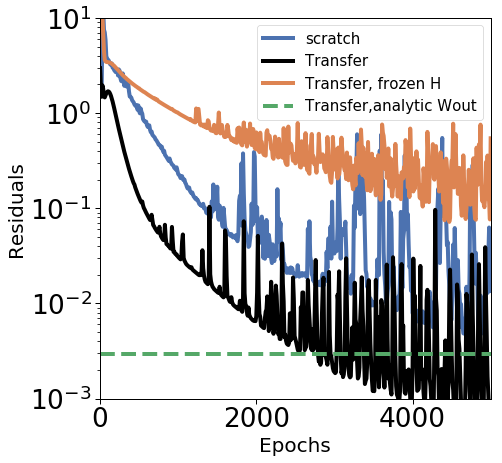

In [36]:
plt.figure(figsize=(7,7))
plt.plot(tpts,exponential_smoothing(residuals_scratch,1),label='scratch')
plt.plot(tpts,exponential_smoothing(residuals1,1),label='Transfer',c='black')
plt.plot(tpts,exponential_smoothing(residuals,1),label='Transfer, frozen H')
# plt.plot(tpts[:len(residuals2)],residuals2,linestyle='--',label='Transfer,analytic Wout')

plt.plot(tpts,(res_init*torch.ones(len(tpts))).detach().numpy(),linestyle='--',label='Transfer,analytic Wout')
plt.yscale('log')
plt.xlabel("Epochs")
plt.ylabel("Residuals")
plt.xlim([0,5000])
plt.ylim([10**-3,10**1])
plt.legend(fontsize=15)
plt.savefig('residuals.pdf',dpi=2400,bbox_inches='tight')